# Adam算法
:label:`sec_adam`

本章我们已经学习了许多有效优化的技术。
在本节讨论之前，我们先详细回顾一下这些技术：

* 在 :numref:`sec_sgd`中，我们学习了：随机梯度下降在解决优化问题时比梯度下降更有效。
* 在 :numref:`sec_minibatch_sgd`中，我们学习了：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。
* 在 :numref:`sec_momentum`中我们添加了一种机制，用于汇总过去梯度的历史以加速收敛。
* 在 :numref:`sec_adagrad`中，我们通过对每个坐标缩放来实现高效计算的预处理器。
* 在 :numref:`sec_rmsprop`中，我们通过学习率的调整来分离每个坐标的缩放。

Adam算法 :cite:`Kingma.Ba.2014`将所有这些技术汇总到一个高效的学习算法中。
不出预料，作为深度学习中使用的更强大和有效的优化算法之一，它非常受欢迎。
但是它并非没有问题，尤其是 :cite:`Reddi.Kale.Kumar.2019`表明，有时Adam算法可能由于方差控制不良而发散。
在完善工作中， :cite:`Zaheer.Reddi.Sachan.ea.2018`给Adam算法提供了一个称为Yogi的热补丁来解决这些问题。
下面我们了解一下Adam算法。

## 算法

Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

## 实现

从头开始实现Adam算法并不难。
为方便起见，我们将时间步$t$存储在`hyperparams`字典中。
除此之外，一切都很简单。


In [1]:
%matplotlib inline
import torch
# from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

现在，我们用以上Adam算法来训练模型，这里我们使用$\eta = 0.01$的学习率。


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

In [3]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

import time
import numpy as np
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.004 sec/epoch


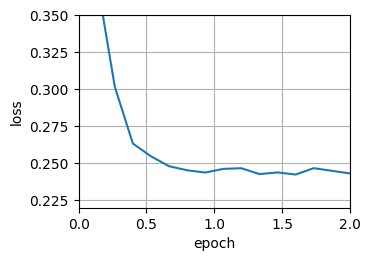

In [4]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

此外，我们可以用深度学习框架自带算法应用Adam算法，这里我们只需要传递配置参数。


In [5]:
from torch import nn
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.243, 0.008 sec/epoch


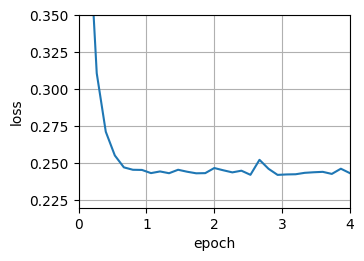

In [6]:
trainer = torch.optim.Adam
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。
 :cite:`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有值很大的变量或更新很稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。


loss: 0.243, 0.007 sec/epoch


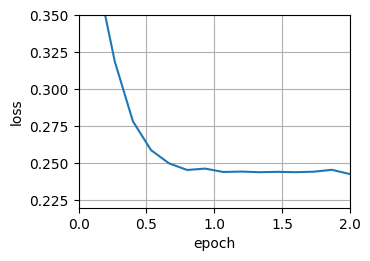

In [7]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 小结

* Adam算法将许多优化算法的功能结合到了相当强大的更新规则中。
* Adam算法在RMSProp算法基础上创建的，还在小批量的随机梯度上使用EWMA。
* 在估计动量和二次矩时，Adam算法使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值$\mathbf{s}_t$来修正它们。Yogi提供了这样的替代方案。

## 练习

1. 调节学习率，观察并分析实验结果。
1. 试着重写动量和二次矩更新，从而使其不需要偏差校正。
1. 收敛时为什么需要降低学习率$\eta$？
1. 尝试构造一个使用Adam算法会发散而Yogi会收敛的例子。


[Discussions](https://discuss.d2l.ai/t/4331)
